### This is The Thid Part of Model Design Stage 

### Part 3 ==============================> Image Based Similarity

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import pairwise_distances
from keras.applications import xception
from keras.applications.xception import preprocess_input
import requests
import os
import shutil
import tensorflow as tf
from PIL import Image
from io import BytesIO

# Image Similarity

In [ ]:
data = pd.read_pickle('pickle_data4')

In order to desing image features we can do it at once but in this case we shoud have about 16GB of Ram more or less in order to that and that's a lot, So in this case i decide to split data into two part and saving the features into 2 files features1 (contain the first 60K rows) and features2 (contain the rest), in this case this would be a little lighter.

As i have stated earlier, I will use transfer learning to get image features or vector, Specifically i will use State-of-the-art Keras model Xception **Without the top layer** which turned out to be very precisie, fast and light and that make it suitable to do this task.

In [ ]:
model = tf.keras.applications.Xception(include_top = False, weights = "imagenet")

83697664/83683744 [==============================] - 1s 0us/step


In [ ]:
# Generate Image Features ==============> Part 1
# Desing new dataframe with two columns vector for image vector and asin to identify images
df = pd.DataFrame(columns = ['vector', 'asin'])
# Define counter variable to monitor the progress
counter = 0
for image, name in zip(filenames, names):
  try:
    # Read the image content using Tensorflow io from the images in our downloaded folder
    img = tf.io.read_file(image)
    # Convert it into jpeg with 3 channels in case not
    img = tf.image.decode_jpeg(img, channels = 3)
    # Resize the image to save memory and processing time [Not Recommended]
    img = tf.image.resize(img, [142, 101])
    # Use process_input predefined function from Xception Keras model
    img = preprocess_input(img)
    # Shrink image float value into float16 rather than float32 to save memory [Not Recommended]
    img = tf.cast(img, dtype = tf.float16)
    # Reshape image neccessary to use Keras model that except 4 dimension inputs
    img = tf.reshape(img, (1,142, 101, 3))
    # Predict the image here without using the last layer of the model to produce result vector
    result = model.predict(img)
    # Flatten the result to get long vector
    result = result.reshape(( 5 * 3 * 2048))
    result = result.astype(np.float16)
    df.loc[counter] = result, name
    counter += 1
  except:
    continue
  # Update result each 10K rows
  if counter % 10000 == 0:
      # Use compression to save memroy on hard disk
      df.to_pickle("features1.pkl", compression = "bz2")
  # Flag to stop processing on 60K rows
  if counter > 60000:
    break

In [ ]:
# Generate Image Features ==============> Part 2
# The same steps goes here but the second part of our data
df = pd.DataFrame(columns = ["vector", "asin"])
counter = 0
thresh = len(filenames) - len(s)
for image, name in zip(filenames, names):
  try:
    if name in s:
      continue
    img = tf.io.read_file(image)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, [142, 101])
    img = preprocess_input(img)
    img = tf.cast(img, dtype = tf.float16)
    img = tf.reshape(img, (1,142, 101, 3))
    result = model.predict(img)
    result = result.reshape(( 5 * 3 * 2048))
    result = result.astype(np.float16)
    df.loc[counter] = result, name
    counter += 1
  except:
    continue
  if counter % 10000 == 0:
      df.to_pickle("features2.pkl", compression = "bz2")
  if counter == thresh:
    df.to_pickle("features2.pkl", compression = "bz2")
    break

In [ ]:
# Run this cell if you wanna merge features1 and features2 togeather in one file
# As I have done compression using bz2 on both of them, we can apply compression on the result
# Rather than allocation about 2.5GB on disk for both files the result with out compression would allocate about 6GB
# It will a littel faster in term of loading, Personally i prefer 2 small files rather than large one
# Even if loading the large one(without compression) will be faster.

# df = pd.DataFrame(np.vstack((d1, d2)), columns = ["vector", "asin"])
# with open("/content/features", 'wb') as f:
#   pickle.dump(df, f, protocol = pickle.HIGHEST_PROTOCOL)

Run the commented cell only if you want to deal with tensorflow dataset but keep in mind that you should have a lot of memory in order to finish it safely.

I decided to use transfer learning rather than trainig CNN model from scratch, specifically i used Keras Xception model with imagenet weights which turn out after traying many models that it outperform VGG16, VGG19 and give 30720 feature with the size of our image.

This model would work even better and give more features if you feed it with optimal image dimension (299 * 299) but resizing and sacrfaicing some features in order to save a lot of memroy would be better in this case.

In [ ]:
# Tensorflow processing pipeline
# Original shape 500h x 356w ----> / 3.5 = 142 x 101
# image_height, image_width = 142, 101
# def process_image(image, name):
#   img = tf.io.read_file(image)
#   img = tf.image.decode_jpeg(img, channels = 3)
#   img = tf.image.resize(img, [image_height, image_width])
#   img = preprocess_input(img)
 
#   return img, name

# trainset = tf.data.Dataset.from_tensor_slices((filenames, names))
# trainset = trainset.map(process_image)

# batch_size = 1
# trainset = trainset.batch(batch_size).cache().prefetch(1)

In [ ]:
# After finishing processing Features1 & Features 2
d1 = pd.read_pickle("features1.pkl", compression = "bz2")
d2 = pd.read_pickle("features2.pkl", compression = "bz2")

In [ ]:
# Reading features file and put it in separated dataframe at first
df1 = pd.DataFrame(np.vstack((d1, d2)), columns = ["vector", "asin"])
# Read the actual data into another dataframe
df2 = pd.read_pickle("pickle_data4")

Now we can drop large_image_url column completely if we have downloaded images folder, or we can keep it and each time we call get_similarity function it will download the products images, the first one is faster because the function only need to read the image from the folder.

In [ ]:
df = pd.merge(df2, df1, on = "asin", how = "outer")
df

,asin,brand,large_image_url,product_type_name,title,vector
0,B01D0ZY642,RB Clothing Co,https://images-na.ssl-images-amazon.com/images...,SHIRT,womens funny racerback tank top training to be...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3877, 0.0, 0...."
1,B074MNBQDP,Antilia Femme,https://images-na.ssl-images-amazon.com/images...,SHIRT,antilia femme tie front floral blouse,"[0.0, 0.0, 0.0, 0.0, 0.4275, 0.0, 0.0, 0.0, 0...."
2,B017UVFKSS,Bubble B,https://images-na.ssl-images-amazon.com/images...,SHIRT,bubble bs two piece like top,"[0.4802, 0.06995, 1.133, 0.0, 0.0, 0.0, 0.0, 0..."
3,B01LXNXM57,FACE N FACE,https://images-na.ssl-images-amazon.com/images...,SHIRT,face n face womens autumn hooded letter printi...,"[0.0, 0.619, 0.0, 0.3435, 0.0, 0.0, 0.1934, 0...."
4,B0742ZCT7T,ASSKDAN Women's Casual Short Sleeves Top Cold ...,https://images-na.ssl-images-amazon.com/images...,SHIRT,asskdan womens casual short sleeves top cold s...,"[0.05585, 0.0, 0.646, 0.0, 0.2932, 0.1157, 0.3..."
...,...,...,...,...,...,...
109490,B071XGPNJ5,TLZC,https://images-na.ssl-images-amazon.com/images...,SHIRT,tlzc womens summer round neck printed rhinesto...,"[0.0, 0.0534, 0.0, 0.0, 0.06137, 0.7583, 0.600..."
109491,B00TJXNAVA,Pink Queen,https://images-na.ssl-images-amazon.com/images...,SHIRT,pink queenemoji digital printed short sleeve t...,"[0.0, 0.0, 0.3484, 0.0, 0.2003, 0.1434, 0.0, 0..."
109492,B071LQ7DGR,Inkach,https://images-na.ssl-images-amazon.com/images...,SHIRT,men button down shirt inkach men summer fashio...,"[1.923, 0.0, 0.616, 0.0, 0.0, 0.0, 0.975, 1.02..."
109493,B072KVSMJC,ViviClo,https://images-na.ssl-images-amazon.com/images...,SHIRT,viviclo womens short sleeve love screen print ...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.464, 0.7007, 0.103..."


In [ ]:
# Function to get the similarity between two images vectors
# Based on vector columns values from the dataframe
# Processing similarity is a lot better than using Pairwise distance based Sickit-Learn
# The latter require a lot of Ram but faster than this method
vec = df.vector.values
def get_similarity(index):
  # Define the target =======> the query row
  # Distance array is the similarity with all other rows
  target, distances = vec[index], np.array([], dtype = np.float16)
  for row in vec:
    distances = np.append(distances, np.linalg.norm(target - row))
  # Return results array
  return distances

In [ ]:
def get_similar(index, k):

  # Get distances array
  distance = get_similarity(index)
  indices = np.argsort(distance.flatten())[:k]
  value_of_nearest = np.sort(distance.flatten())[:k]
  
  # Root folder of downloaded images
  root_folder = "Images/"
  for i in range(k):
    # Get the row in the dataframe
    row = df.loc[indices[i]]
    if i == 0:
      print("The Query Data:")
    
    plt.imshow(plt.imread(root_folder + row["asin"] + '.jpeg'))
    plt.axis("off")
    plt.show()
    print()
    print("ASIN:", row["asin"])
    print("Type:", row["product_type_name"])
    print("Brand:", row["brand"])
    print("Title:", row["title"])
    print("Distance between two data points =", int(value_of_nearest[i]))
    print("-" * 100)

The Query Data:


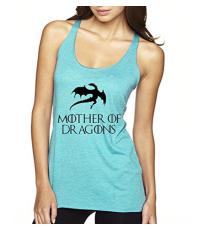


ASIN: B01LTAPR7K
Type: SHIRT
Brand: Wild Bobby
Title: mother of dragons got premium triblend racerback womens tank top 
Distance between two data points = 0
----------------------------------------------------------------------------------------------------


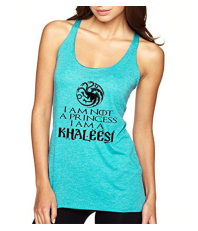


ASIN: B01LTCE2Q0
Type: SHIRT
Brand: Wild Bobby
Title: i am not a princess i a khaleesi got premium triblend racerback womens tank top 
Distance between two data points = 28
----------------------------------------------------------------------------------------------------


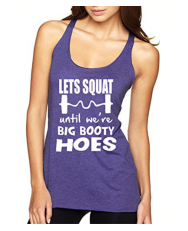


ASIN: B06X19GGRQ
Type: SHIRT
Brand: The Workout Princess
Title: lets squat until were big booty hoes  funny printed tank top workout fitness shirt deep round neck sleeveless women 
Distance between two data points = 45
----------------------------------------------------------------------------------------------------


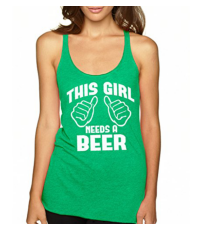


ASIN: B010TWTP2C
Type: SHIRT
Brand: SignatureTshirts
Title: signaturetshirts womens saint patricks this girl needs a beer racerback tank 
Distance between two data points = 48
----------------------------------------------------------------------------------------------------


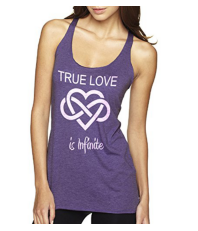


ASIN: B01NCY7WIW
Type: SHIRT
Brand: Vicko
Title: true love infinite vicko womens premium triblend racerback tank 
Distance between two data points = 49
----------------------------------------------------------------------------------------------------


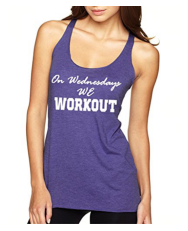


ASIN: B06VVTHS4S
Type: SHIRT
Brand: The Workout Princess
Title: motivation inspiration sexy fitness apparel womens wednesdays workout tank pink 
Distance between two data points = 49
----------------------------------------------------------------------------------------------------


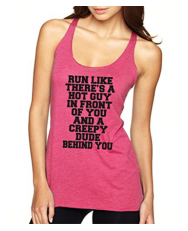


ASIN: B06X6H5KY2
Type: SHIRT
Brand: The Workout Princess
Title: running tank gym trail funny printed workout fitness tank women 
Distance between two data points = 50
----------------------------------------------------------------------------------------------------


In [ ]:
get_similar(index = 5, k = 7)

The Query Data:


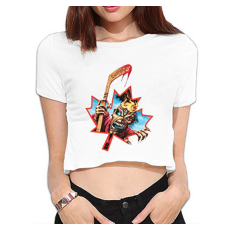


ASIN: B01GJ1WI1W
Type: SHIRT
Brand: KIUBY9JJKOP
Title: iron maiden crop top short sleeve t shirt shirt printing tee shirt easeful womens 
Distance between two data points = 0
----------------------------------------------------------------------------------------------------


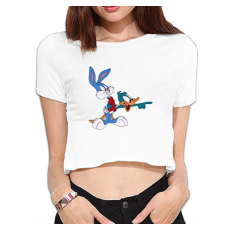


ASIN: B01LRXMWTA
Type: SHIRT
Brand: POLOP
Title: tiny toon adventures looney tunes tshirts nice navel tshirts 
Distance between two data points = 41
----------------------------------------------------------------------------------------------------


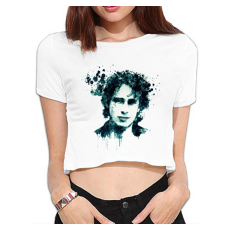


ASIN: B01M0ER53G
Type: SHIRT
Brand: MEGGE Present
Title: megge female jeff buckley sport dew navel white 
Distance between two data points = 42
----------------------------------------------------------------------------------------------------


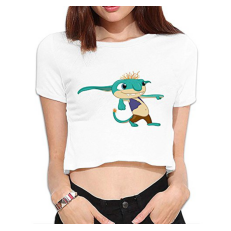


ASIN: B01FFEOEGQ
Type: SHIRT
Brand: Frank
Title: womens wallykazam bobgoblin classic summer expose navel tee tshirt white us size 
Distance between two data points = 42
----------------------------------------------------------------------------------------------------


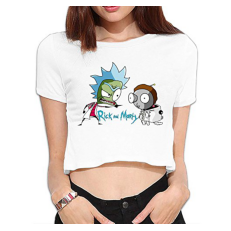


ASIN: B01L8XJAJE
Type: SHIRT
Brand: MEGGE Present
Title: megge female rick and morty5 comfortable dew navel 
Distance between two data points = 48
----------------------------------------------------------------------------------------------------


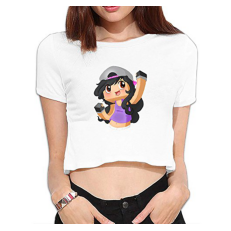


ASIN: B01HL91X4O
Type: SHIRT
Brand: Aphmau S1jb
Title: aphmau logo shirts online girl dew navel attire tshirt sport 
Distance between two data points = 50
----------------------------------------------------------------------------------------------------


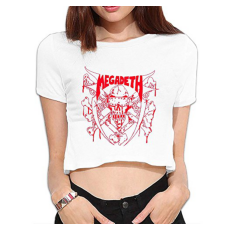


ASIN: B01G1K82A2
Type: SHIRT
Brand: zhe
Title: comfortable summer black crop shirt megadeth women 
Distance between two data points = 50
----------------------------------------------------------------------------------------------------


In [ ]:
get_similar(index = 7160, k = 7)

The Query Data:


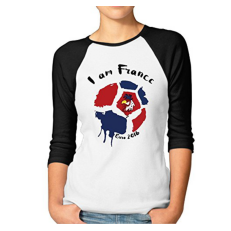


ASIN: B01GQ42Y20
Type: SHIRT
Brand: A-Lin
Title: alin womens uefa euro 2016 france 34 sleeve baseball tshirts 
Distance between two data points = 0
----------------------------------------------------------------------------------------------------


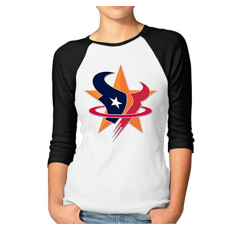


ASIN: B01K4GBKLC
Type: SHIRT
Brand: ElishaJ
Title: elishaj womens raglan 34 sleeve tshirt houston sports logo mixed black 
Distance between two data points = 33
----------------------------------------------------------------------------------------------------


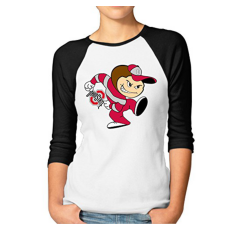


ASIN: B01IBGPA22
Type: SHIRT
Brand: HOHOE Custom
Title: hohoe womens 34 sleeve raglan ohio state university plain baseball tshirt black 
Distance between two data points = 34
----------------------------------------------------------------------------------------------------


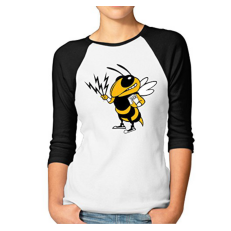


ASIN: B01LXZTVEV
Type: SHIRT
Brand: JXMD
Title: jxmd womens georgia institute of technology tshirt black 
Distance between two data points = 35
----------------------------------------------------------------------------------------------------


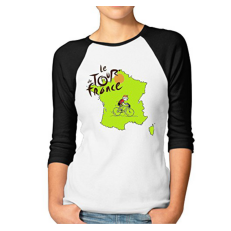


ASIN: B01HZJ4LYY
Type: SHIRT
Brand: A-Lin
Title: alin womens cycling tour de france 2016 roadmap 34 sleeve baseball tshirts 
Distance between two data points = 35
----------------------------------------------------------------------------------------------------


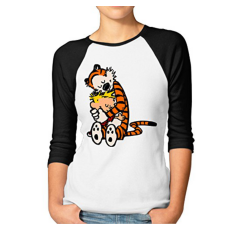


ASIN: B01LS1MHB4
Type: SHIRT
Brand: NINJOE
Title: ninjoe ladys 34 raglan calvin and hobbes hug baseball tees black 
Distance between two data points = 36
----------------------------------------------------------------------------------------------------


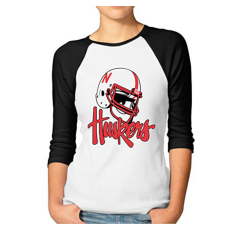


ASIN: B01IES7BGK
Type: SHIRT
Brand: Nebraska Huskers Bh7f
Title: nebraska huskers logo raglan sleeve womens 34 sleeve tshirts casualsexy 
Distance between two data points = 36
----------------------------------------------------------------------------------------------------


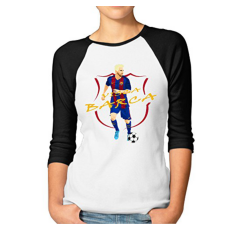


ASIN: B01M1JSG6T
Type: SHIRT
Brand: CAYE
Title: barcelona visca barca messi womens love 100 cotton 34 sleeve athletic baseball raglan sleeves tshirt 
Distance between two data points = 36
----------------------------------------------------------------------------------------------------


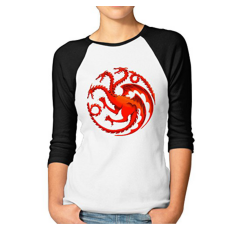


ASIN: B01J1OBSLA
Type: SHIRT
Brand: Game of Thrones
Title: game of thrones raglan sleeve womens 34 sleeve t shirt oneckfashionable 
Distance between two data points = 37
----------------------------------------------------------------------------------------------------


In [ ]:
get_similar(index = 55623, k = 9)

The Query Data:


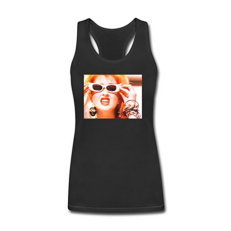


ASIN: B01LXD8OEE
Type: SHIRT
Brand: YZH
Title: yzh hot 2016 womens cyndi lauper 2016 poster tank top lady black 
Distance between two data points = 0
----------------------------------------------------------------------------------------------------


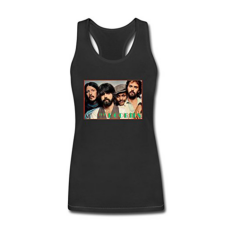


ASIN: B01LY0LGP2
Type: SHIRT
Brand: Cwenen
Title: womens 2016 the doobie brothers members tank top 
Distance between two data points = 33
----------------------------------------------------------------------------------------------------


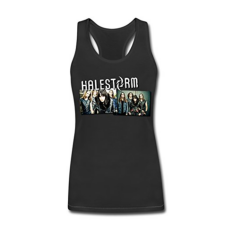


ASIN: B01HNU5L1W
Type: SHIRT
Brand: Bround
Title: ladys 2016 halestorm poster summer tank tops 
Distance between two data points = 51
----------------------------------------------------------------------------------------------------


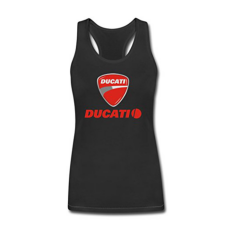


ASIN: B01LKNDEGW
Type: SHIRT
Brand: Cwenen
Title: womens ducati car red logo 04 tank top 
Distance between two data points = 52
----------------------------------------------------------------------------------------------------


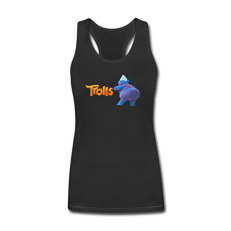


ASIN: B01M0M8HKN
Type: SHIRT
Brand: Cwenen
Title: womens trolls poster tank top 
Distance between two data points = 54
----------------------------------------------------------------------------------------------------


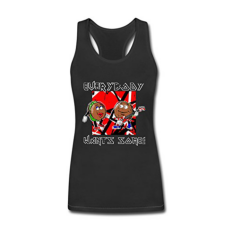


ASIN: B01K15BTA8
Type: SHIRT
Brand: TOGEB
Title: togeb everybody wants some 2016 women tank top tshirt vest black 
Distance between two data points = 55
----------------------------------------------------------------------------------------------------


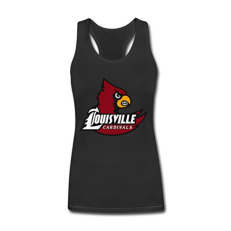


ASIN: B01KBQLDXA
Type: SHIRT
Brand: Padaeot
Title: 2016 louisville cardinals womens summer tank top 
Distance between two data points = 55
----------------------------------------------------------------------------------------------------


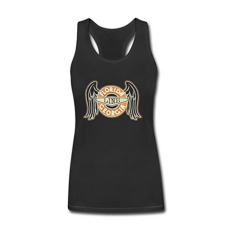


ASIN: B01L8VQDO6
Type: SHIRT
Brand: WBG
Title: wbg diy womens florida georgia line fashion shirt tank top ladyblack 
Distance between two data points = 56
----------------------------------------------------------------------------------------------------


In [ ]:
get_similar(index = 100000, k = 8)

Wow!, the result of using image features is amazing, i did not see that coming it's really a very good predictor but there is only one problem in it, It suffer from lacking of diversity and variance as it always prefre the same shape of the product exactly everytime and that's expected because it's preffer the products with similar features and product with similar features have the same pixels values.

Now it's time to combine all what we have done already in one predictor in order to get the final results.